### Explication techniques du captioning

Dans cette cellule, on configure l'environnement et on importe les librairies nécessaires pour notre projet de captioning d'images.

#### 1. Suppression des avertissements
- On utilise `warnings.filterwarnings('ignore')` pour éviter que des messages d'avertissement ne perturbent l'affichage des résultats.
- On configure TensorFlow pour réduire les logs techniques avec `os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'`.

#### 2. Importation des librairies principales
- **Manipulation des données** :
  - `numpy` et `pandas` pour gérer les données numériques et tabulaires.
  - `pickle` pour sauvegarder et charger des objets Python.
  - `tqdm` pour afficher une barre de progression dans les boucles.
- **Gestion des textes** :
  - `textwrap` pour formater les textes.

#### 3. Outils de visualisation
- `matplotlib` est configuré pour personnaliser les graphiques (par exemple, la taille de police).
- `seaborn` est utilisé pour créer des visualisations esthétiques avec un style sombre par défaut.

#### 4. Modules TensorFlow/Keras
- Ces outils sont utilisés pour le traitement des images et des textes, ainsi que pour la création et l'entraînement de modèles de deep learning :
  - Chargement et prétraitement des données (images et textes).
  - Création et personnalisation des architectures de modèles.
  - Gestion de l'entraînement avec des callbacks (sauvegarde des modèles, ajustement du taux d'apprentissage, etc.).

#### 5. Interface utilisateur graphique (GUI)
- On importe des modules pour créer une interface utilisateur avec `tkinter` et `PIL`.
- Cela permet d’ajouter une interaction utilisateur, comme la sélection de fichiers ou l’affichage d’images.

---

### Résumé
Cette cellule prépare l'environnement en :
- Supprimant les avertissements inutiles.
- Important des outils pour manipuler les données, créer des modèles de deep learning, visualiser les résultats, et intégrer une interface utilisateur.


In [1]:
# Suppression des avertissements et configuration
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Librairies de base
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from textwrap import wrap

# Visualisation
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
import seaborn as sns
sns.set_style("dark")

# TensorFlow et Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Dense, Input, Embedding, LSTM, Dropout,
    Reshape, concatenate, add
)

# GUI
import tkinter as tk
from tkinter import filedialog, ttk
from PIL import Image, ImageTk


In [2]:
image_path = 'flickr8k/Images'
data = pd.read_csv("flickr8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...




Dans cette cellule, on définit deux fonctions : `readImage` et `display_images`, qui sont utilisées pour lire et afficher des images avec leurs légendes.

#### 1. Fonction `readImage`
- **Objectif** : Charger une image depuis un chemin donné, la redimensionner, et la normaliser.
- **Étapes** :
  - `load_img` : Charge une image en mode couleur (`rgb`) et la redimensionne à une taille carrée spécifiée par `img_size` (par défaut 224x224 pixels).
  - `img_to_array` : Convertit l'image en un tableau NumPy pour permettre son traitement.
  - Normalisation : Les valeurs des pixels sont divisées par 255 pour les ramener dans la plage [0, 1], ce qui est standard dans les modèles de deep learning.

#### 2. Fonction `display_images`
- **Objectif** : Afficher un ensemble d'images avec leurs légendes associées.
- **Étapes** :
  - On réinitialise l'index du DataFrame fourni (`temp_df`) pour garantir un affichage ordonné.
  - Une figure de taille 20x20 est créée pour afficher les images.
  - Une boucle de 15 itérations :
    - Charge les images à partir du dossier `flickr8k/Images/` en utilisant la fonction `readImage`.
    - Affiche chaque image dans une sous-grille de 5x5.
    - Affiche la légende associée à l'image, formatée avec `wrap` pour limiter la largeur du texte à 20 caractères.
    - Supprime les axes pour un affichage plus propre.
  - On ajuste les espaces entre les sous-graphiques pour une meilleure lisibilité avec `plt.subplots_adjust`.

---

### Résumé
- La fonction `readImage` permet de charger, redimensionner et normaliser une image pour la rendre compatible avec les modèles de deep learning.
- La fonction `display_images` affiche un ensemble d'images et leurs légendes dans une grille organisée, en utilisant `matplotlib`.


In [3]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

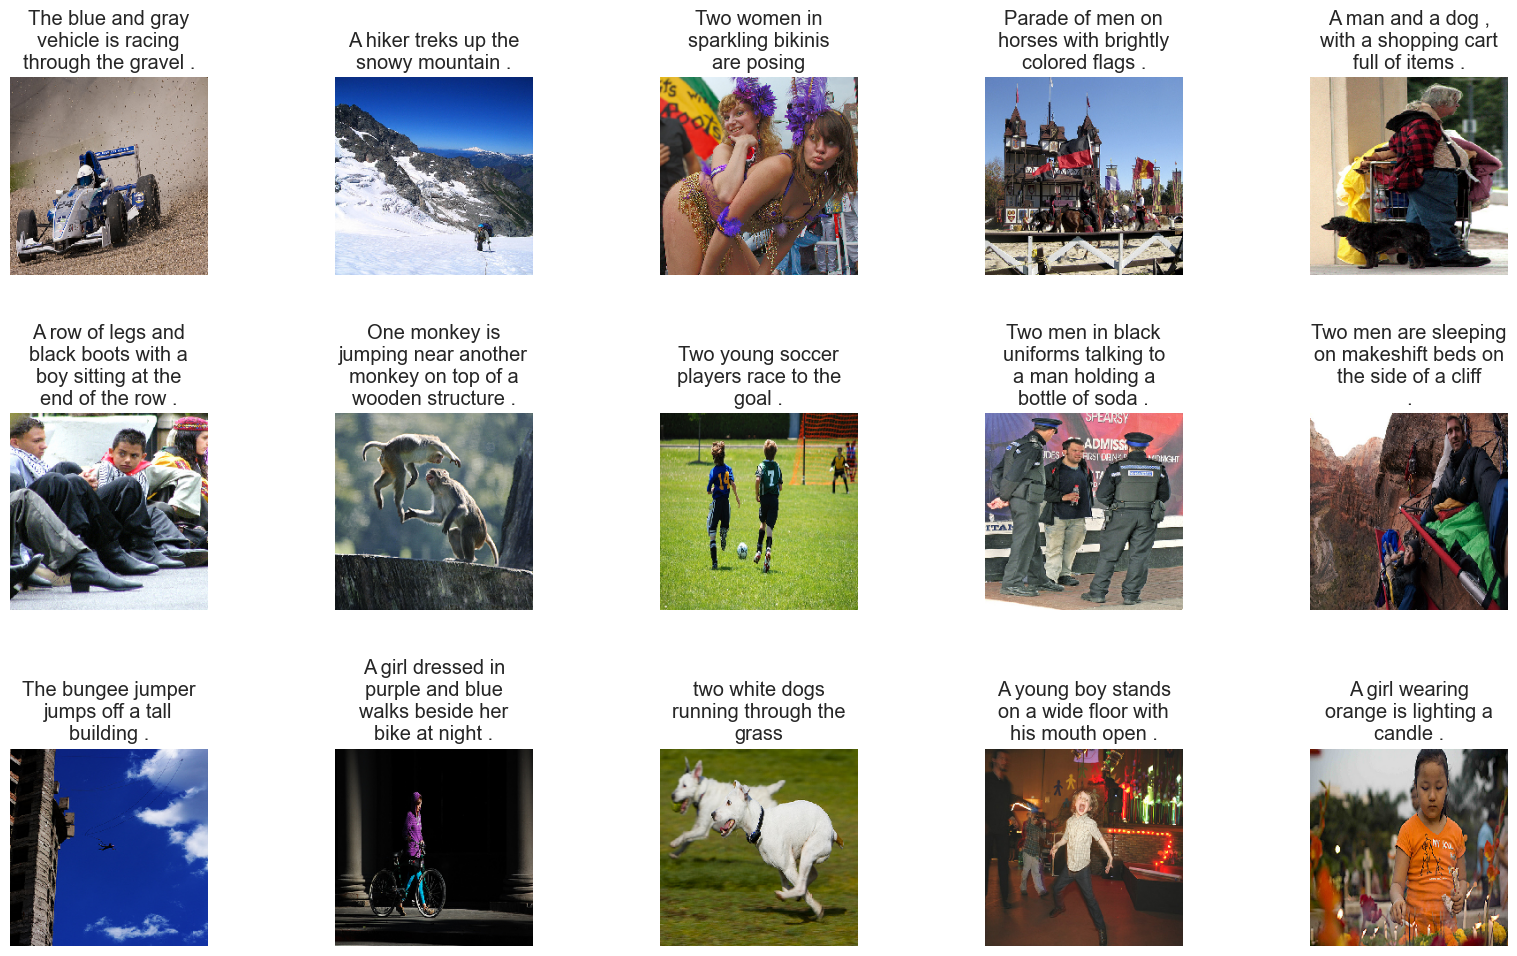

In [4]:
display_images(data.sample(15))

In [5]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [6]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']



Dans cette cellule, nous préparons les légendes et les données pour l'entraînement en effectuant la tokenisation, la sauvegarde des paramètres importants, et la séparation des données.

#### 1. Tokenisation des légendes
- **Objectif** : Transformer les légendes en séquences numériques pour qu'on puisse les utiliser dans un modèle de deep learning.
- **Étapes** :
  - On crée un tokenizer avec `Tokenizer()`, qui attribue un index unique à chaque mot des légendes (`captions`).
  - On ajuste le tokenizer aux légendes avec `fit_on_texts(captions)`.
  - On calcule la taille du vocabulaire (`vocab_size`), qui correspond au nombre de mots uniques + 1 (pour tenir compte de l'indexation à partir de 1).
  - On détermine la longueur maximale d'une légende (`max_length`) en mesurant le nombre de mots dans la légende la plus longue.

#### 2. Sauvegarde des paramètres
- **Objectif** : Sauvegarder le tokenizer et la longueur maximale pour pouvoir les réutiliser plus tard (par exemple, lors de l'entraînement ou pour de nouvelles prédictions).
- **Étapes** :
  - On utilise `pickle` pour sauvegarder un dictionnaire contenant le tokenizer et `max_length` dans un fichier appelé `tokenizer.pkl`.

#### 3. Séparation des données en ensembles d'entraînement et de validation
- **Objectif** : Diviser nos données en deux groupes distincts pour l'entraînement et l'évaluation.
- **Étapes** :
  - On récupère les noms uniques des images dans la colonne `image`.
  - On calcule le nombre total d'images (`nimages`) et on définit un index pour séparer les données en 85 % pour l'entraînement et 15 % pour la validation.
  - On divise les images en deux listes : `train_images` (pour l'entraînement) et `val_images` (pour la validation).
  - On filtre nos données initiales (`data`) pour créer deux sous-ensembles :
    - `train` : Contient les lignes correspondant aux images d'entraînement.
    - `test` : Contient les lignes correspondant aux images de validation.
  - On réinitialise les index des deux DataFrames (`train` et `test`) pour que les données soient bien organisées.

#### 4. Exemple de conversion de texte en séquence
- On vérifie que le tokenizer fonctionne en transformant la deuxième légende de la liste `captions` en une séquence numérique avec `texts_to_sequences`.

---

### Résumé
Dans cette cellule, nous avons préparé les légendes et les données en :
- Transformant les textes en séquences numériques grâce au tokenizer.
- Sauvegardant les paramètres essentiels pour une réutilisation future.
- Divisant les données en ensembles d'entraînement et de validation.
- Fournissant un exemple pour vérifier que la tokenisation fonctionne correctement.


In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

# Sauvegarder le tokenizer et max_length
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump({'tokenizer': tokenizer, 'max_length': max_length}, f)


images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]



Dans cette cellule, on utilise le modèle DenseNet201 pour extraire des caractéristiques des images.

#### 1. Chargement du modèle DenseNet201
- On charge le modèle DenseNet201 pré-entraîné et on crée un nouveau modèle `fe` qui extrait les caractéristiques de l'avant-dernière couche du réseau.

#### 2. Extraction des caractéristiques des images
- On définit la taille d'image à 224x224 pixels et on parcourt chaque image du dataset.
- Pour chaque image, on la charge, on la prépare (redimensionnement et normalisation), puis on extrait ses caractéristiques à l'aide du modèle `fe`.
- Les caractéristiques sont ensuite stockées dans un dictionnaire, où chaque image est associée à ses caractéristiques.

---

### Résumé
On utilise DenseNet201 pour extraire des caractéristiques des images et on les stocke dans un dictionnaire pour chaque image.


In [8]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 8091/8091 [34:33<00:00,  3.90it/s]  


In [9]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y



Dans cette cellule, on définit et compile un modèle pour la génération de légendes d'images.

#### 1. Définition des entrées
- On crée deux entrées : une pour les caractéristiques de l'image (`input1`) et une pour les séquences de mots des légendes (`input2`).

#### 2. Traitement des caractéristiques d'image
- Les caractéristiques de l'image sont passées à travers une couche Dense, puis remodelées pour correspondre à la forme attendue par le modèle.

#### 3. Traitement des séquences de mots
- On applique une couche d'Embedding aux séquences de mots, transformant les mots en vecteurs de taille 256.

#### 4. Fusion des caractéristiques image et texte
- Les caractéristiques d'image et les séquences de mots sont fusionnées, puis passées dans une couche LSTM pour capturer la relation entre les deux.
- On ajoute une couche Dropout pour éviter le surapprentissage et une couche Dense pour affiner la sortie.

#### 5. Sortie du modèle
- La sortie du modèle est une prédiction des mots de la légende, générée à l'aide d'une activation `softmax`.

#### 6. Compilation du modèle
- Le modèle est compilé avec la fonction de perte `categorical_crossentropy` et l'optimiseur `adam`.

---

### Résumé
On définit un modèle qui prend les caractéristiques d'une image et une séquence de mots en entrée pour générer une légende d'image. Le modèle est compilé avec une fonction de perte adaptée et un optimiseur pour l'entraînement.


In [10]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [11]:
plot_model(caption_model)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [12]:
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    491,776 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,172,160 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 35, 256)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8485)      │  1,094,565 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,316,709 (16.47 MB)

 Trainable params: 4,316,709 (16.47 MB)

 Non-trainable params: 0 (0.00 B)

### Explication de la cellule

Dans cette cellule, on entraîne le modèle de génération de légendes d'images en utilisant un générateur de données personnalisé et des callbacks pour l'entraînement.

#### 1. Création des générateurs de données
- On crée deux générateurs de données (`train_generator` et `validation_generator`) à l'aide de la classe `CustomDataGenerator`. Ces générateurs chargent les images et leurs légendes, en utilisant le tokenizer, les caractéristiques des images, et d'autres paramètres pour l'entraînement.

#### 2. Définition des callbacks
- **ModelCheckpoint** : Sauvegarde le meilleur modèle pendant l'entraînement en fonction de la perte de validation.
- **EarlyStopping** : Arrête l'entraînement si la perte de validation ne s'améliore pas pendant 5 epochs, et restaure les meilleurs poids.
- **ReduceLROnPlateau** : Réduit le taux d'apprentissage si la perte de validation ne s'améliore pas après 3 epochs.

#### 3. Entraînement du modèle
- On entraîne le modèle en utilisant `fit`, avec les générateurs de données pour l'entraînement et la validation. On utilise les callbacks pour améliorer l'entraînement et éviter le surapprentissage.

---

### Résumé
On crée des générateurs de données pour l'entraînement et la validation, puis on entraîne le modèle en utilisant des callbacks pour optimiser l'apprentissage, comme la sauvegarde du meilleur modèle et l'ajustement du taux d'apprentissage.


In [13]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [14]:
model_name = "caption_model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [15]:
history = caption_model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction],
        verbose=0)


Epoch 1: val_loss improved from inf to 4.30152, saving model to caption_model.keras

Epoch 2: val_loss improved from 4.30152 to 3.97514, saving model to caption_model.keras

Epoch 3: val_loss improved from 3.97514 to 3.81583, saving model to caption_model.keras

Epoch 4: val_loss improved from 3.81583 to 3.73041, saving model to caption_model.keras

Epoch 5: val_loss improved from 3.73041 to 3.68728, saving model to caption_model.keras

Epoch 6: val_loss improved from 3.68728 to 3.64883, saving model to caption_model.keras

Epoch 7: val_loss improved from 3.64883 to 3.61960, saving model to caption_model.keras

Epoch 8: val_loss did not improve from 3.61960

Epoch 9: val_loss did not improve from 3.61960

Epoch 10: val_loss did not improve from 3.61960

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 11: val_loss did not improve from 3.61960

Epoch 12: val_loss did not improve from 3.61960
Epoch 12: early stopping
Restoring model weights from the e

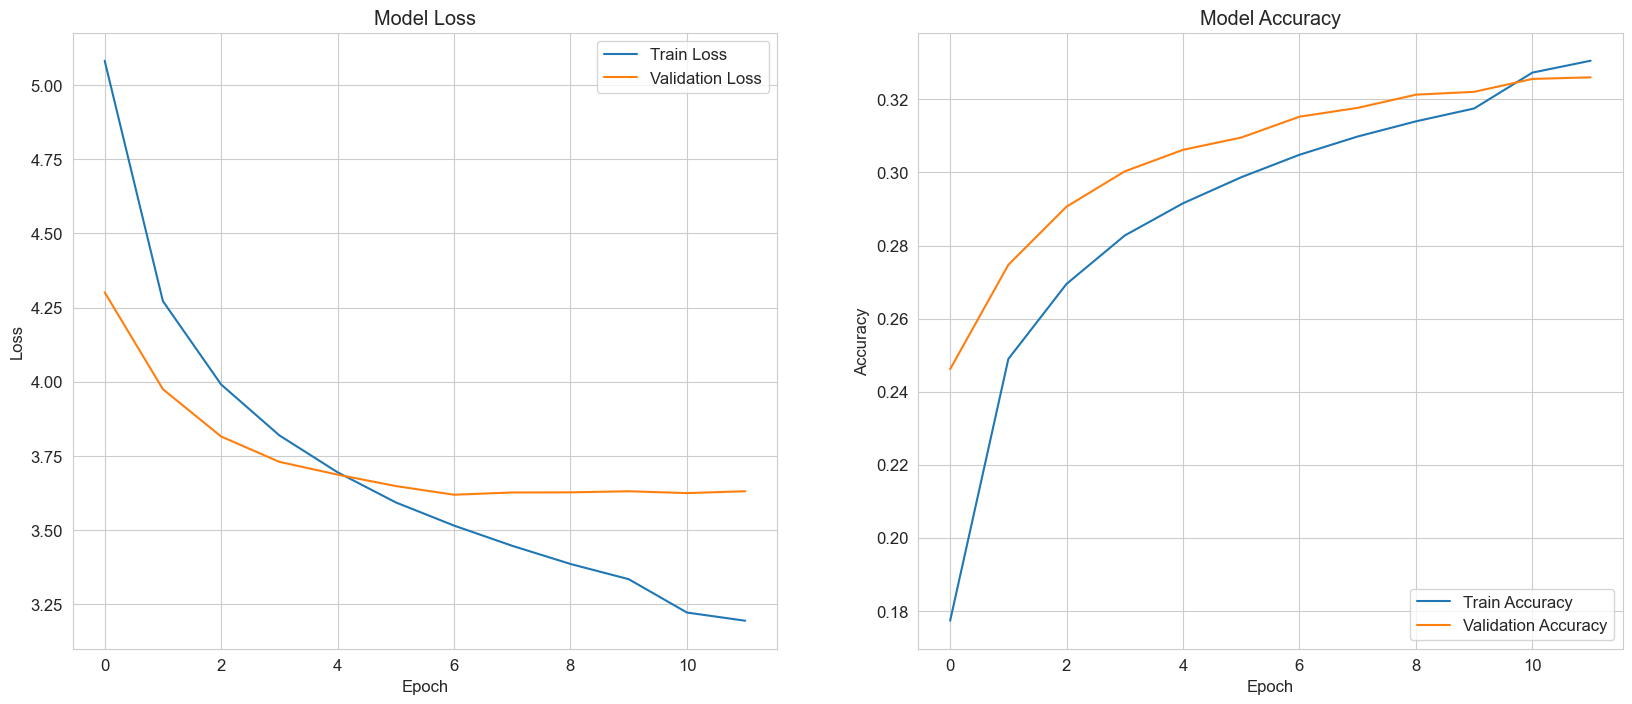

In [16]:
plt.figure(figsize=(20,8))

# Subplot pour la loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Subplot pour l'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.show()


### Explication de la cellule

Dans cette cellule, on prédit des légendes pour un échantillon d'images en utilisant le modèle entraîné.

#### 1. Fonction `idx_to_word`
- La fonction `idx_to_word` prend un entier (index) et retourne le mot correspondant à cet index à partir du tokenizer.

#### 2. Fonction `predict_caption`
- La fonction `predict_caption` génère une légende pour une image donnée.
- Elle commence par le mot "startseq" et prédit un mot à la fois en utilisant le modèle. La séquence de mots est mise à jour à chaque prédiction, et la prédiction s'arrête si le mot "endseq" est généré ou si la longueur maximale de la légende est atteinte.

#### 3. Prédiction des légendes pour un échantillon
- On sélectionne un échantillon de 15 images à partir du jeu de test.
- Pour chaque image, on charge l'image, on prédit sa légende en appelant `predict_caption`, puis on ajoute la légende prédite à l'échantillon.

---

### Résumé
On génère des légendes pour un échantillon d'images en utilisant le modèle de prédiction. Chaque légende est générée mot par mot et ajoutée à l'échantillon.


In [17]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [18]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [19]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [20]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

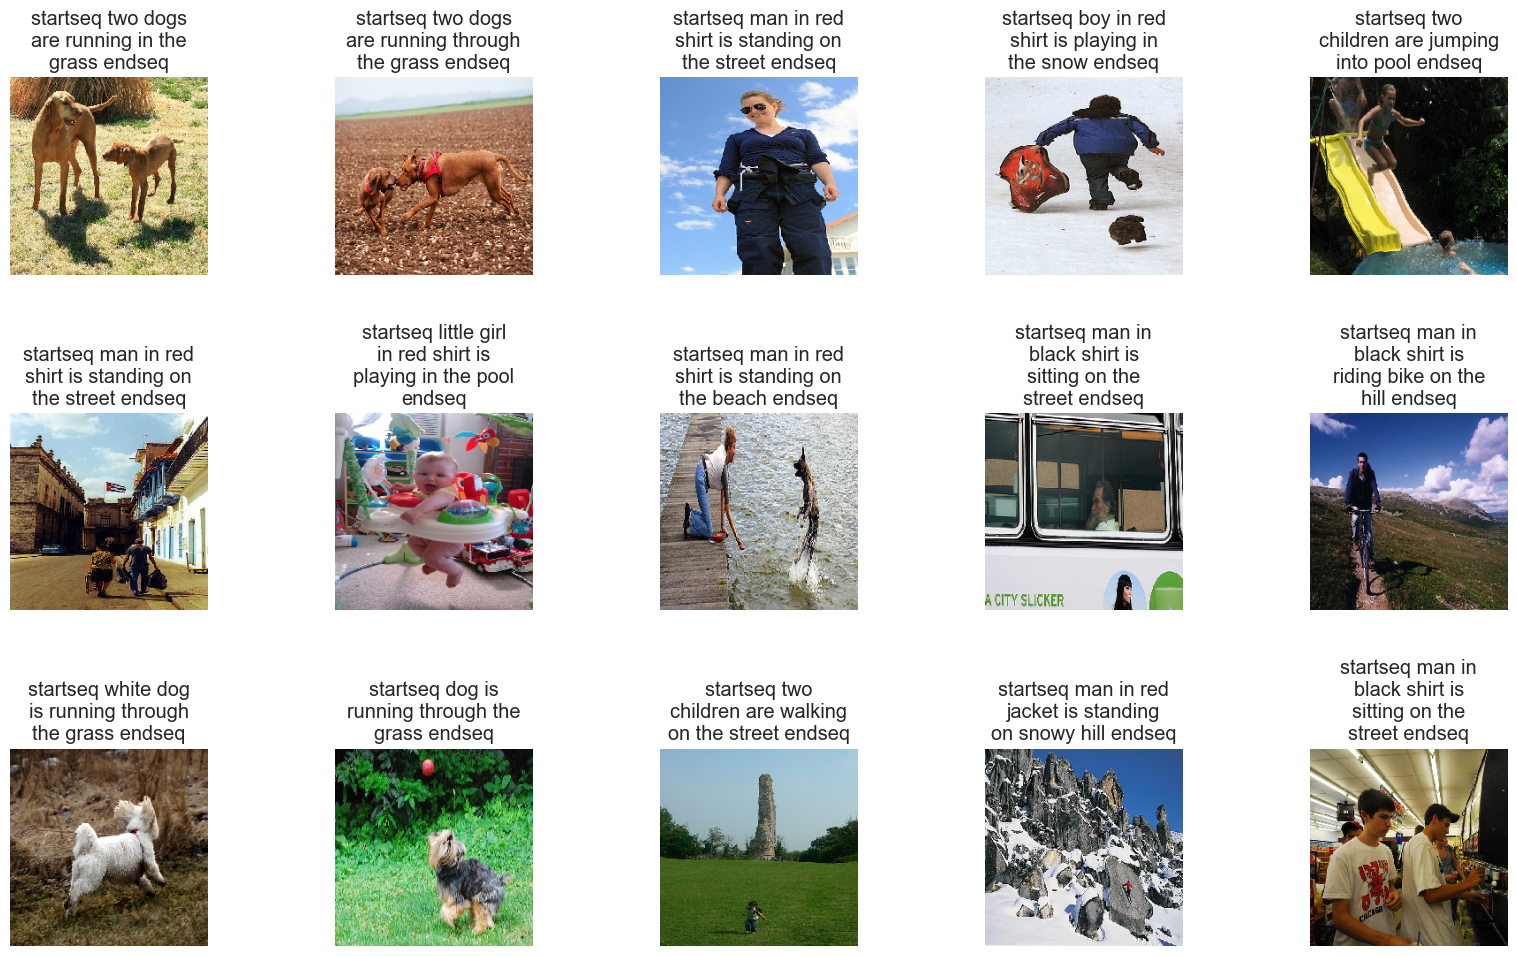

In [21]:
display_images(samples)

### Explication de la cellule

Dans cette cellule, on crée une application graphique (GUI) permettant de charger une image et de générer une légende pour celle-ci à l'aide d'un modèle pré-entraîné.

#### 1. Classe `ImageCaptionApp`
- **`__init__`** : Cette méthode initialise l'application. Elle charge le modèle de prédiction de légendes (`caption_model.keras`) et le tokenizer utilisé pour générer les légendes. Elle configure également le modèle DenseNet pour extraire les caractéristiques des images.
- **`setup_gui`** : Configure l'interface graphique de l'application. Elle crée un bouton pour charger une image, une zone d'affichage pour l'image et une zone de texte pour afficher la description générée.

#### 2. Méthodes de l'application
- **`load_image`** : Cette méthode permet de charger une image à partir de l'ordinateur de l'utilisateur. L'image est ensuite affichée dans l'interface graphique, et la génération de la légende est lancée.
- **`extract_features`** : Extrait les caractéristiques d'une image à l'aide du modèle DenseNet pré-entraîné.
- **`idx_to_word`** : Convertit un indice en mot à l'aide du tokenizer.
- **`predict_caption`** : Génère la légende pour une image en prédisant un mot à la fois jusqu'à atteindre la longueur maximale ou le mot "endseq".
- **`generate_caption`** : Appelle la méthode `predict_caption` pour générer la légende de l'image actuellement chargée et l'affiche dans l'interface graphique.

#### 3. Lancement de l'application
- **`__main__`** : L'application démarre en créant une fenêtre tkinter, en initialisant la classe `ImageCaptionApp` et en lançant la boucle principale de l'interface graphique.

---

### Résumé
Cette cellule crée une application tkinter permettant de charger une image, de prédire une légende pour celle-ci à l'aide d'un modèle de deep learning, et d'afficher la légende générée dans l'interface graphique.


In [22]:
class ImageCaptionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Générateur de descriptions d'images")

        # Chargement du modèle et du tokenizer
        print("Chargement du modèle...")
        self.caption_model = tf.keras.models.load_model('caption_model.keras')
        print("Chargement du tokenizer...")
        # Chargement du tokenizer et de max_length
        with open('tokenizer.pkl', 'rb') as f:
            data = pickle.load(f)
            self.tokenizer = data['tokenizer']
            self.max_length = data['max_length']


        # Configuration du modèle DenseNet pour l'extraction des caractéristiques
        model = DenseNet201()
        self.feature_extractor = tf.keras.Model(inputs=model.input,
                                              outputs=model.layers[-2].output)

        print(f"Longueur maximale de séquence: {self.max_length}")

        self.setup_gui()

    def setup_gui(self):
        # Frame principale
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))

        # Bouton pour charger l'image
        self.load_btn = ttk.Button(main_frame,
                                   text="Charger une image",
                                   command=self.load_image)
        self.load_btn.grid(row=0, column=0, pady=10)

        # Zone d'affichage de l'image
        self.image_label = ttk.Label(main_frame)
        self.image_label.grid(row=1, column=0, pady=10)

        # Zone de texte pour la description
        self.description_var = tk.StringVar()
        self.description_label = ttk.Label(main_frame,
                                           textvariable=self.description_var,
                                           wraplength=400)
        self.description_label.grid(row=2, column=0, pady=10)


    def load_image(self):
        file_path = filedialog.askopenfilename(
            filetypes=[("Images", "*.jpg *.jpeg *.png *.bmp *.gif *.tiff")]
        )

        if file_path:
            # Charger et redimensionner l'image pour l'affichage
            self.current_image_path = file_path
            image = Image.open(file_path)
            image = image.resize((224, 224))
            self.photo = ImageTk.PhotoImage(image)  # Maintenir une référence persistante

            self.image_label.configure(image=self.photo)
            self.image_label.image = self.photo  # Éviter la collecte par le garbage collector

            self.description_var.set("Génération de la description en cours...")
            self.root.update()  # Mettre à jour l'interface utilisateur

            # Appeler automatiquement la génération de la description
            self.generate_caption()

    def extract_features(self, image_path):
        img = load_img(image_path, target_size=(224, 224))
        img = img_to_array(img)
        img = img/255.
        img = np.expand_dims(img, axis=0)
        feature = self.feature_extractor.predict(img, verbose=0)
        return feature

    def idx_to_word(self, integer):
        for word, index in self.tokenizer.word_index.items():
            if index == integer:
                return word
        return None

    def predict_caption(self, image_path):
        feature = self.extract_features(image_path)
        in_text = "startseq"

        for i in range(self.max_length):
            sequence = self.tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=self.max_length)

            try:
                y_pred = self.caption_model.predict([feature, sequence], verbose=0)
                y_pred = np.argmax(y_pred)

                word = self.idx_to_word(y_pred)

                if word is None:
                    break

                in_text += " " + word

                if word == 'endseq':
                    break
            except Exception as e:
                print(f"Erreur lors de la prédiction: {str(e)}")
                print(f"Shape de sequence: {sequence.shape}")
                print(f"Shape de feature: {feature.shape}")
                raise e

        return in_text

    def generate_caption(self):
        if hasattr(self, 'current_image_path'):
            self.description_var.set("Génération de la description en cours...")
            self.root.update()

            try:
                caption = self.predict_caption(self.current_image_path)
                # Nettoyer la description
                caption = caption.replace('startseq', '').replace('endseq', '').strip()

                self.description_var.set(caption)
            except Exception as e:
                self.description_var.set(f"Erreur lors de la génération: {str(e)}")


if __name__ == "__main__":
    root = tk.Tk()
    app = ImageCaptionApp(root)
    root.mainloop()

Chargement du modèle...
Chargement du tokenizer...
Longueur maximale de séquence: 34
